# Financial Chatbot :Advanced RAG with Llama 3

## Overview

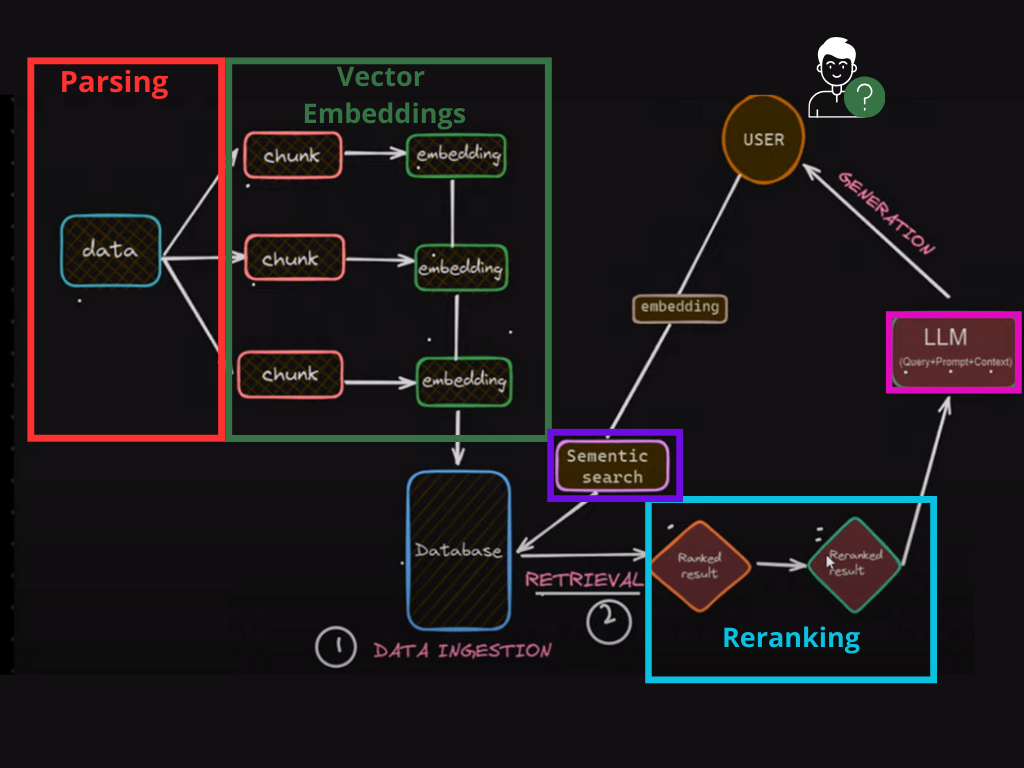

In [ ]:
!pip -qqq install pip --progress-bar off
!pip -qqq install langchain-groq==0.1.3 --progress-bar off
!pip -qqq install langchain==0.1.17 --progress-bar off
!pip -qqq install llama-parse==0.1.3 --progress-bar off
!pip -qqq install qdrant-client==1.9.1  --progress-bar off
!pip -qqq install "unstructured[md]"==0.13.6 --progress-bar off
!pip -qqq install fastembed==0.2.7 --progress-bar off
!pip -qqq install flashrank==0.2.4 --progress-bar off

In [ ]:
import os
import textwrap
from pathlib import Path

from google.colab import userdata
from IPython.display import Markdown
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import FlashrankRerank
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Qdrant
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain_community.embeddings.fastembed import FastEmbedEmbeddings
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from llama_parse import LlamaParse


def print_response(response):
    response_txt = response["result"]
    for chunk in response_txt.split("\n"):
        if not chunk:
            print()
            continue
        print("\n".join(textwrap.wrap(chunk, 100, break_long_words=False)))

In [ ]:
!mkdir data
!gdown 1ee-BhQiH-S9a2IkHiFbJz9eX_SfcZ5m9 -O "data/meta-earnings.pdf"

Downloading...
From: https://drive.google.com/uc?id=1ee-BhQiH-S9a2IkHiFbJz9eX_SfcZ5m9
To: /content/data/meta-earnings.pdf
100% 160k/160k [00:00<00:00, 72.0MB/s]


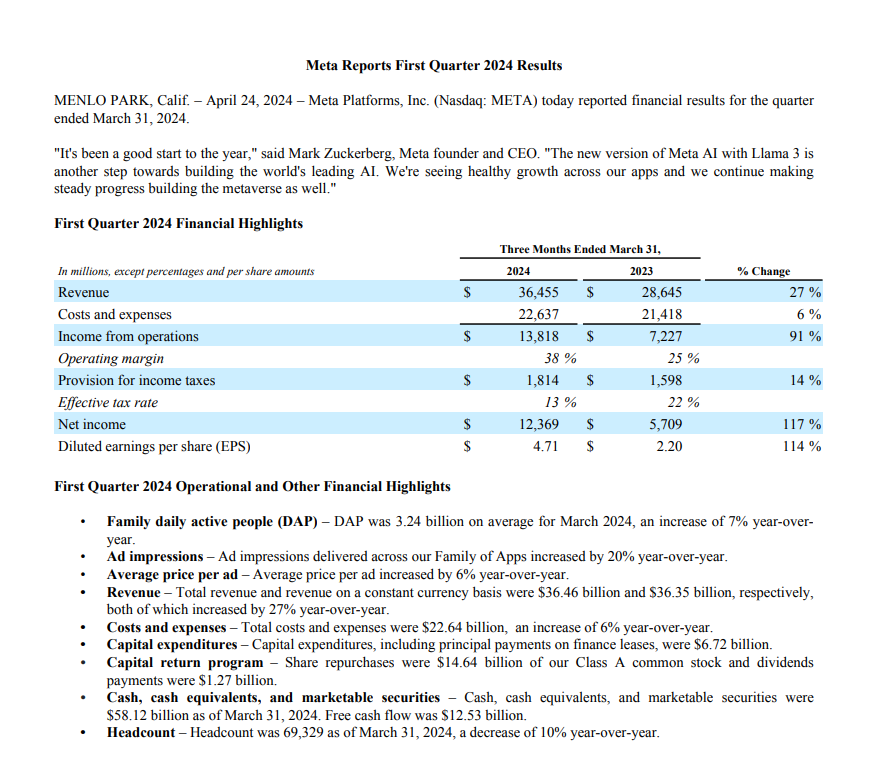

## Document Parsing


In this section, we are automating the process of extracting and analyzing financial data from a PDF document (Meta's First Quarter 2024 Results). The document includes unaudited financial statements, management discussions, and other required disclosures. The goal is to use **Llama Parse**, a tool specifically designed for parsing large text-heavy documents, to accurately extract the important content from this complex file.

The extraction process involves:
1. **Defining Instructions for Parsing**: We provide clear guidance to Llama Parse with an instruction that emphasizes the financial nature of the document and the importance of precise extraction, especially from tables.
2. **Setting Up Llama Parse API**: Using an API key, we interact with Llama Parse to perform the extraction in real-time.
3. **Extracting Content into Markdown Format**: The parsed document is returned as a markdown file for easy navigation and further analysis, allowing us to quickly review the content and highlight relevant financial information.

This approach not only speeds up the document analysis process but also ensures that we get structured, clean data, particularly from complex sections like financial tables, which would be difficult and time-consuming to process manually.

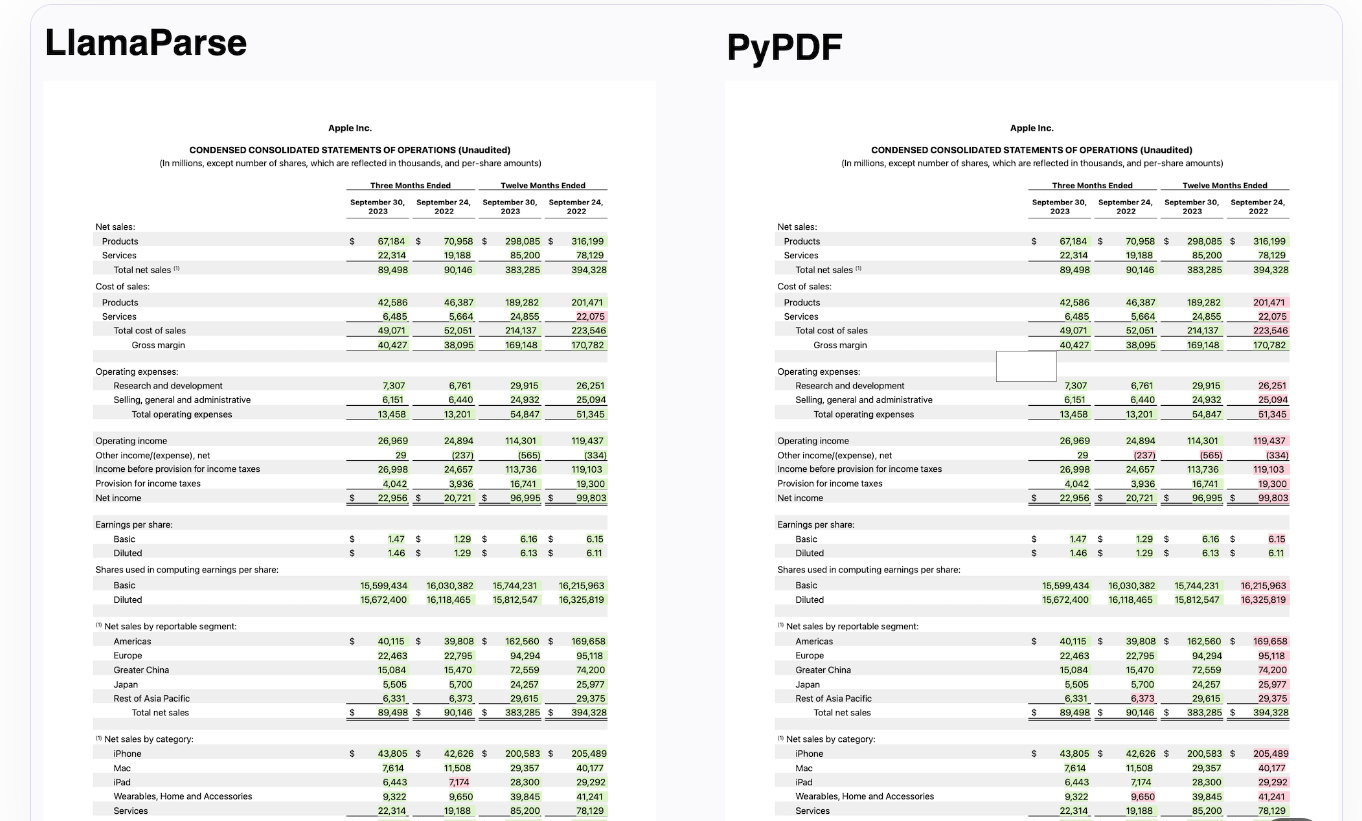

In [ ]:
instruction = """The provided document is Meta First Quarter 2024 Results.
This form provides detailed financial information about the company's performance for a specific quarter.
It includes unaudited financial statements, management discussion and analysis, and other relevant disclosures required by the SEC.
It contains many tables.
Try to be precise while answering the questions"""


# Set the Llama Parse API key
os.environ["LLAMA_PARSE"] = "llx-Lg6fVB2O1U3rCM2CzVBMG8LJuArWLuYJQOVG2TSyAzuDxBaT"

parser = LlamaParse(
    api_key=os.environ.get("LLAMA_PARSE"),
    result_type="markdown",
    parsing_instruction=instruction,
    max_timeout=5000,
)

llama_parse_documents = await parser.aload_data("./data/meta-earnings.pdf")

Started parsing the file under job_id d7565091-d965-49bf-9892-8e38022643df


This line indicates that the parsing process for the specified PDF file has begun. The job_id is a unique identifier generated by the Llama Parse API for this specific parsing job. It allows to track or reference this job later, which can be useful for debugging or monitoring purposes.

In [ ]:
parsed_doc = llama_parse_documents[0]

In [ ]:
Markdown(parsed_doc.text[:4096])

# Meta Reports First Quarter 2024 Results

MENLO PARK, Calif. – April 24, 2024 – Meta Platforms, Inc. (Nasdaq: META) today reported financial results for the quarter ended March 31, 2024.

"It's been a good start to the year," said Mark Zuckerberg, Meta founder and CEO. "The new version of Meta AI with Llama 3 is another step towards building the world's leading AI. We're seeing healthy growth across our apps and we continue making steady progress building the metaverse as well."

# First Quarter 2024 Financial Highlights

|In millions, except percentages and per share amounts|2024|2023|% Change|
|---|---|---|---|
|Revenue|$ 36,455|$ 28,645|27 %|
|Costs and expenses|$ 22,637|$ 21,418|6 %|
|Income from operations|$ 13,818|$ 7,227|91 %|
|Operating margin|38 %|25 %| |
|Provision for income taxes|$ 1,814|$ 1,598|14 %|
|Effective tax rate|13 %|22 %| |
|Net income|$ 12,369|$ 5,709|117 %|
|Diluted earnings per share (EPS)|$ 4.71|$ 2.20|114 %|

# First Quarter 2024 Operational and Other Financial Highlights

- Family daily active people (DAP) – DAP was 3.24 billion on average for March 2024, an increase of 7% year-over-year.
- Ad impressions – Ad impressions delivered across our Family of Apps increased by 20% year-over-year.
- Average price per ad – Average price per ad increased by 6% year-over-year.
- Revenue – Total revenue and revenue on a constant currency basis were $36.46 billion and $36.35 billion, respectively, both of which increased by 27% year-over-year.
- Costs and expenses – Total costs and expenses were $22.64 billion, an increase of 6% year-over-year.
- Capital expenditures – Capital expenditures, including principal payments on finance leases, were $6.72 billion.
- Capital return program – Share repurchases were $14.64 billion of our Class A common stock and dividends payments were $1.27 billion.
- Cash, cash equivalents, and marketable securities – Cash, cash equivalents, and marketable securities were $58.12 billion as of March 31, 2024. Free cash flow was $12.53 billion.
- Headcount – Headcount was 69,329 as of March 31, 2024, a decrease of 10% year-over-year.
---
# CFO Outlook Commentary

We expect second quarter 2024 total revenue to be in the range of $36.5-39 billion. Our guidance assumes foreign currency is a 1% headwind to year-over-year total revenue growth, based on current exchange rates.

We expect full-year 2024 total expenses to be in the range of $96-99 billion, updated from our prior outlook of $94-99 billion due to higher infrastructure and legal costs. For Reality Labs, we continue to expect operating losses to increase meaningfully year-over-year due to our ongoing product development efforts and our investments to further scale our ecosystem.

We anticipate our full-year 2024 capital expenditures will be in the range of $35-40 billion, increased from our prior range of $30-37 billion as we continue to accelerate our infrastructure investments to support our artificial intelligence (AI) roadmap. While we are not providing guidance for years beyond 2024, we expect capital expenditures will continue to increase next year as we invest aggressively to support our ambitious AI research and product development efforts.

Absent any changes to our tax landscape, we expect our full-year 2024 tax rate to be in the mid-teens.

In addition, we continue to monitor an active regulatory landscape, including the increasing legal and regulatory headwinds in the EU and the U.S. that could significantly impact our business and our financial results.

Q1 was a good start to the year. We're seeing strong momentum within our Family of Apps and are making important progress on our longer-term AI and Reality Labs initiatives that have the potential to transform the way people interact with our services over the coming years.
---
# Webcast and Conference Call Information

Meta will host a conference call to discuss the results at 2:00 p.m. PT / 5:00 p.m. ET today. The live webcast of Meta's earnings conference call can be accessed at investor.fb.com, along with the earnings press release, financial tables, and slide

In [ ]:
document_path = Path("data/parsed_document.md")
with document_path.open("a") as f:
    f.write(parsed_doc.text)

## Vector Embeddings

In [ ]:
loader = UnstructuredMarkdownLoader(document_path)
loaded_documents = loader.load()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=2048, chunk_overlap=128) #Each chunk has a maximum size of 2048
                                                                                  #characters with an overlap of 128 characters to maintain contextual integrity.

docs = text_splitter.split_documents(loaded_documents)
len(docs)

11

In [ ]:
print(docs[0].page_content)

Meta Reports First Quarter 2024 Results

MENLO PARK, Calif. – April 24, 2024 – Meta Platforms, Inc. (Nasdaq: META) today reported financial results for the quarter ended March 31, 2024.

"It's been a good start to the year," said Mark Zuckerberg, Meta founder and CEO. "The new version of Meta AI with Llama 3 is another step towards building the world's leading AI. We're seeing healthy growth across our apps and we continue making steady progress building the metaverse as well."

First Quarter 2024 Financial Highlights

In millions, except percentages and per share amounts 2024 2023 % Change Revenue $ 36,455 $ 28,645 27 % Costs and expenses $ 22,637 $ 21,418 6 % Income from operations $ 13,818 $ 7,227 91 % Operating margin 38 % 25 % Provision for income taxes $ 1,814 $ 1,598 14 % Effective tax rate 13 % 22 % Net income $ 12,369 $ 5,709 117 % Diluted earnings per share (EPS) $ 4.71 $ 2.20 114 %

First Quarter 2024 Operational and Other Financial Highlights

Family daily active people (DA

In [ ]:
embeddings = FastEmbedEmbeddings(model_name="BAAI/bge-base-en-v1.5") #This transforms textual data into numerical
                                                                    #representations, capturing the semantic meaning of the text.

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/740 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

model_optimized.onnx:   0%|          | 0.00/218M [00:00<?, ?B/s]

### 1.Qdrant Setup for Storing Embeddings

1. **What is Qdrant?**
   - **Qdrant** is an open-source vector database designed to store and efficiently retrieve high-dimensional vectors. It is optimized for machine learning applications, particularly for tasks involving similarity search, recommendation systems, and other scenarios requiring quick access to vector representations.

2. **Why Use Qdrant?**
   - **Efficiency:** Qdrant is optimized for handling large volumes of embeddings, allowing for quick and efficient retrieval of similar vectors based on a query.
   - **Scalability:** It can scale with your data, accommodating growing datasets without significant performance degradation.
   - **Flexible Querying:** Qdrant supports various querying capabilities, including filtering and scoring based on custom criteria, making it suitable for complex search tasks.

3. **How It Works:**
   - Once the Qdrant instance is set up, it stores the vector embeddings along with any associated metadata from the documents. This enables  to perform similarity searches effectively, as the embeddings can be quickly compared against new queries to find relevant results.



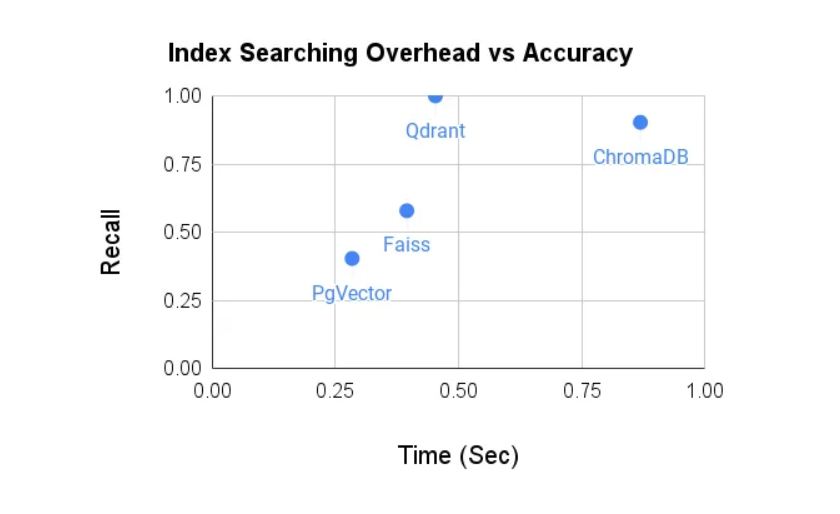

In [ ]:
qdrant = Qdrant.from_documents(
    docs,
    embeddings,
    path="./db",
    collection_name="document_embeddings",
)


   - **Parameters Explained:**
     - `docs`: This parameter is the list of documents that you have previously processed and split into chunks. Each document will be transformed into a vector embedding.
     - `embeddings`: This refers to the embedding model I’ve created (`FastEmbedEmbeddings`). It is responsible for converting the documents into vector representations.
     - `path="./db"`: This specifies the storage location for your Qdrant database. The database will be created in a directory named `db` within your current working directory. If the directory does not exist, Qdrant will create it.
     - `collection_name="document_embeddings"`: This defines a specific collection within the Qdrant instance where the embeddings will be stored. Collections help organize data within the database, making it easier to manage and retrieve relevant embeddings later.


### 2.Similarity Search in Qdrant

1. **Objective:**
   - This  aims to perform a similarity search in the Qdrant database to identify relevant documents based on a specific user query. This allows for quick and efficient extraction of pertinent information.

2. **Executing a Similarity Search:**
   - A query is defined to determine the information we want to retrieve, specifically regarding important innovations from Meta.
   - The similarity search is then executed in the Qdrant instance, returning documents that are most similar to the query along with their corresponding similarity scores, which indicate the degree of match.

3. **Timing the Search:**
   - The execution time for the similarity search is measured to assess the performance of the search operation.

4. **Displaying Results:**
   - After retrieving the similar documents, the results are presented in a structured format. Each document’s content is displayed along with its similarity score, allowing for a quick review of the most relevant results.



In [ ]:
%%time
query = "What is the most important innovation from Meta?"
similar_docs = qdrant.similarity_search_with_score(query)

CPU times: user 268 ms, sys: 4.92 ms, total: 273 ms
Wall time: 276 ms


In [ ]:
for doc, score in similar_docs:
    print(f"id: {doc.metadata['_id']}\n")
    print(f"text: {doc.page_content[:256]}\n")
    print(f"score: {score}")
    print("-" * 80)
    print()

id: 6531c6c97ce44c9bb7381ba8d89635ad

text: Meta Reports First Quarter 2024 Results

MENLO PARK, Calif. – April 24, 2024 – Meta Platforms, Inc. (Nasdaq: META) today reported financial results for the quarter ended March 31, 2024.

"It's been a good start to the year," said Mark Zuckerberg, Meta foun

score: 0.6171858025785488
--------------------------------------------------------------------------------

id: 8d636244f12f4526ad6cfa82deb11d5b

text: Webcast and Conference Call Information

Meta will host a conference call to discuss the results at 2:00 p.m. PT / 5:00 p.m. ET today. The live webcast of Meta's earnings conference call can be accessed at investor.fb.com, along with the earnings press rel

score: 0.5703670704616712
--------------------------------------------------------------------------------

id: cc167c73a6e34ec4858cccd14d0edc7a

text: Reconciliation of cash, cash equivalents, and restricted cash to the condensed consolidated balance sheets

Cash and cash equivalents $ 

5. **Using the Qdrant Retriever:**
   - A retriever is set up to facilitate more advanced querying. The retriever is configured to return the top five most relevant documents based on the initial query.

6. **Retrieving and Displaying Document IDs:**
   - Each retrieved document is printed with its unique ID, providing additional context and enabling easier tracking of specific entries in the database.


In [ ]:
%%time
retriever = qdrant.as_retriever(search_kwargs={"k": 5})
retrieved_docs = retriever.invoke(query)

CPU times: user 295 ms, sys: 36.9 ms, total: 332 ms
Wall time: 332 ms


In [ ]:
for doc in retrieved_docs:
    print(f"id: {doc.metadata['_id']}\n")
    print(f"text: {doc.page_content[:256]}\n")
    print("-" * 80)
    print()

id: 6531c6c97ce44c9bb7381ba8d89635ad

text: Meta Reports First Quarter 2024 Results

MENLO PARK, Calif. – April 24, 2024 – Meta Platforms, Inc. (Nasdaq: META) today reported financial results for the quarter ended March 31, 2024.

"It's been a good start to the year," said Mark Zuckerberg, Meta foun

score: 0.47436779594694456
--------------------------------------------------------------------------------

id: 8d636244f12f4526ad6cfa82deb11d5b

text: Webcast and Conference Call Information

Meta will host a conference call to discuss the results at 2:00 p.m. PT / 5:00 p.m. ET today. The live webcast of Meta's earnings conference call can be accessed at investor.fb.com, along with the earnings press rel

score: 0.47436779594694456
--------------------------------------------------------------------------------

id: cc167c73a6e34ec4858cccd14d0edc7a

text: Reconciliation of cash, cash equivalents, and restricted cash to the condensed consolidated balance sheets

Cash and cash equivalents 

The relevance scoring algorithm  prioritize documents based on the presence of keywords or phrases that match your query. Since the document does not specifically mention innovations, they receive lower scores.

## Reranking


1. **Objective:**
   - This section focuses on enhancing the results of the initial document retrieval process by applying a reranking mechanism. The goal is to improve the relevance of the retrieved documents based on their contextual similarities to the user's query.

2. **Setting Up the Reranker:**
   - A reranker is instantiated using the `FlashrankRerank` class with the pre-trained model `ms-marco-MiniLM-L-12-v2`. This model is specifically designed to improve the ranking of search results by evaluating their relevance.

**Flash Rank**: Ultra-lite & Super-fast Python library for search & retrieval re-ranking.

- **Ultra-lite**: No heavy dependencies.
- **Super-fast**: Speed depends on the number of tokens in passages and query, plus model depth.
- **Cost-efficient**: Ideal for serverless deployments with low memory and time requirements.
- **Based on State-of-the-Art Cross-encoders**: Includes models like ms-marco-TinyBERT-L-2-v2 (default), **ms-marco-MiniLM-L-12-v2**, rank-T5-flan, and ms-marco-MultiBERT-L-12.
- **Sleek Models for Efficiency**: Designed for minimal overhead in user-facing scenarios.

_Flash Rank is tailored for scenarios requiring efficient and effective reranking, balancing performance with resource usage._

  

3. **Creating a Compression Retriever:**
   - The `ContextualCompressionRetriever` is created, combining the base compressor and the previously defined retriever. This setup allows for reranking the documents retrieved in the initial search.


4. **Reranking Documents:**
   - The reranking process is executed by invoking the compression retriever with the original query. This results in a new list of documents that have been reordered based on their relevance to the query.

In [ ]:
compressor = FlashrankRerank(model="ms-marco-MiniLM-L-12-v2")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=retriever
)

ms-marco-MiniLM-L-12-v2.zip: 100%|██████████| 21.6M/21.6M [00:00<00:00, 57.1MiB/s]


In [ ]:
%%time
reranked_docs = compression_retriever.invoke(query)
len(reranked_docs)

Running pairwise ranking..
CPU times: user 2.59 s, sys: 76.3 ms, total: 2.67 s
Wall time: 2.65 s


3


5. **Displaying Reranked Results:**
   - The reranked documents are presented in a structured format, including each document's unique ID, a snippet of its content, and its relevance score. The relevance score provides insight into how well each document matches the query after the reranking process.

6. **Conclusion:**
   - This segment effectively demonstrates the implementation of a reranking strategy to enhance the quality of document retrieval. By leveraging advanced models, the system can provide more relevant and contextually aligned results to user queries.


In [ ]:
for doc in reranked_docs:
    print(f"id: {doc.metadata['_id']}\n")
    print(f"text: {doc.page_content[:256]}\n")
    print(f"score: {doc.metadata['relevance_score']}")
    print("-" * 80)
    print()

id: 6531c6c97ce44c9bb7381ba8d89635ad

text: Meta Reports First Quarter 2024 Results

MENLO PARK, Calif. – April 24, 2024 – Meta Platforms, Inc. (Nasdaq: META) today reported financial results for the quarter ended March 31, 2024.

"It's been a good start to the year," said Mark Zuckerberg, Meta foun

score: 0.16551902890205383
--------------------------------------------------------------------------------

id: 8d636244f12f4526ad6cfa82deb11d5b

text: Webcast and Conference Call Information

Meta will host a conference call to discuss the results at 2:00 p.m. PT / 5:00 p.m. ET today. The live webcast of Meta's earnings conference call can be accessed at investor.fb.com, along with the earnings press rel

score: 0.006210770923644304
--------------------------------------------------------------------------------

id: 9cdc9b8423b446148628bc1a7aa4121a

text: This press release contains forward-looking statements regarding our future business plans and expectations. These forward-looking st

## Q&A Over Document

## 1. **Initialization of the Large Language Model**

### What is Groq?
Groq is an AI solutions company known for its cutting-edge technology, particularly the Language Processing Unit (LPU) Inference Engine, designed to enhance Large Language Models (LLMs) with ultra-low latency inference capabilities. Groq APIs enable developers to integrate state-of-the-art LLMs like Llama3 and Mixtral 8x7B into applications requiring real-time AI processing.

The ChatGroq class uses the Groq chat LLM APIs. To instantiate the class we need to provide the model_name and groq_api_key. I am using the " llama3-70b-8192 " model in my example.

ChatGroq would be used to run LLMs to generate human-like text responses

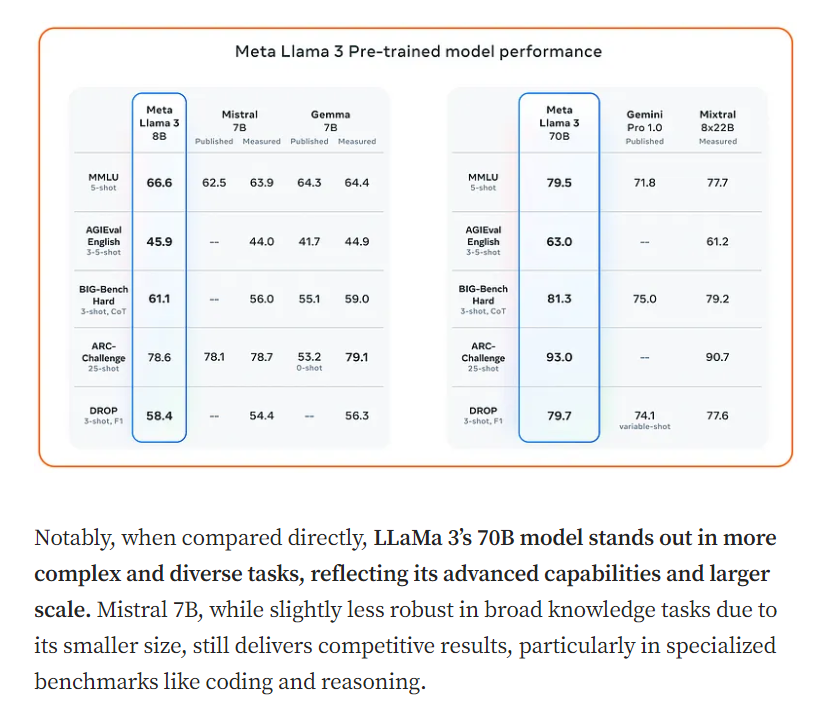

In [ ]:
os.environ["GROQ_API_KEY"] = "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"

llm = ChatGroq(temperature=0, model_name="llama3-70b-8192") # A temperature setting of 0 means that the model will generate the most
                                                            #deterministic and focused response by choosing the highest-probability tokens without randomness.


## 2. **Prompt Template Definition**
Next, I define a prompt template that guides the LLM in how to respond to user queries. The template includes:
- Instructions to use the provided context to formulate answers.
- Guidance for the model to acknowledge when it doesn't know an answer, preventing the generation of inaccurate information.
- A structure for the response that makes it easy to read and comprehend.


In [ ]:
prompt_template = """
Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: {context}
Question: {question}

Answer the question and provide additional helpful information,
based on the pieces of information, if applicable. Be succinct.

Responses should be properly formatted to be easily read.
"""

prompt = PromptTemplate(
    template=prompt_template, input_variables=["context", "question"]
)


## 3. **Setup of the Q&A Chain**
Using the `RetrievalQA.from_chain_type()` method, I create a Q&A chain that integrates the LLM and a document retrieval system. The main configurations include:

* llm=llm: This specifies the language model to use for generating answers. In your case, it would be the Llama 3 model (or whichever LLM you assigned to the variable llm).
* chain_type="stuff": This indicates the type of chain to use for processing. "Stuff" typically means that the retrieved documents will be concatenated together to form the context for the LLM before generating an answer.
* retriever=compression_retriever: This parameter specifies the document retrieval method. The compression_retriever likely compresses or summarizes documents to improve the efficiency and relevance of the retrieved context.
* return_source_documents=True: This flag indicates that the system should return the source documents from which the answer was derived. This is useful for transparency and verification.
* chain_type_kwargs={"prompt": prompt, "verbose": True}: This provides additional options for configuring the chain type. Here, it passes a specific prompt to guide the LLM’s responses and sets verbosity to true, which likely enables more detailed output during processing.
(verbose=**True**: Detailed output for debugging and tracking processes.
verbose=**False**: Concise output, only showing essential information.)




In [ ]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=compression_retriever,
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt, "verbose": True},
)


## 4. **Invoking the Q&A System**
Finally, I invoke the Q&A system by querying it with the question: **"What is the most significant innovation from Meta?"**
This triggers the retrieval of relevant documents and generates a concise answer based on the retrieved context.

To evaluate the efficiency of the system, I use the `%%time` magic command to measure the execution time of the Q&A process.

This implementation showcases how LLMs can be leveraged in conjunction with document retrieval systems to provide accurate and contextually relevant answers to user inquiries.


In [ ]:
%%time
response = qa.invoke("What is the most significant innovation from Meta?")

Running pairwise ranking..


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:

Use the following pieces of information to answer the user's question.
If you don't know the answer, just say that you don't know, don't try to make up an answer.

Context: Meta Reports First Quarter 2024 Results

MENLO PARK, Calif. – April 24, 2024 – Meta Platforms, Inc. (Nasdaq: META) today reported financial results for the quarter ended March 31, 2024.

"It's been a good start to the year," said Mark Zuckerberg, Meta founder and CEO. "The new version of Meta AI with Llama 3 is another step towards building the world's leading AI. We're seeing healthy growth across our apps and we continue making steady progress building the metaverse as well."

First Quarter 2024 Financial Highlights

In millions, except percentages and per share amounts 2024 2023 % Change Revenue $ 36,455 $ 28,645 27 % Costs and expenses $ 22,637 $ 21,418 6 % Income from operations 

In [ ]:
print_response(response)

Based on the provided information, the most significant innovation from Meta is the new version of
Meta AI with Llama 3, which is mentioned in the quote from Mark Zuckerberg, Meta founder and CEO.
This innovation is part of Meta's efforts to build the world's leading AI.

Additionally, the press release highlights Meta's progress in building the metaverse, which is
another significant innovation from the company. However, the exact details of this innovation are
not provided in the given information.


In [ ]:
%%time
response = qa.invoke("What is the revenue for 2024 and % change?")

Running pairwise ranking..
CPU times: user 2.62 s, sys: 14 ms, total: 2.64 s
Wall time: 3.18 s


In [ ]:
Markdown(response["result"])

**Revenue for 2024 and % Change:**

The revenue for 2024 is $36,455 million, which represents a 27% year-over-year change.

**Additional Helpful Information:**

* Revenue excluding foreign exchange effect is $36,349 million, which also represents a 27% year-over-year change.
* Advertising revenue for 2024 is $35,635 million, which represents a 27% year-over-year change. Advertising revenue excluding foreign exchange effect is $35,530 million, which represents a 26% year-over-year change.

In [ ]:
%%time
response = qa.invoke("What is the revenue for 2023?")

Running pairwise ranking..
CPU times: user 2.58 s, sys: 2.26 ms, total: 2.58 s
Wall time: 3.02 s


In [ ]:
print_response(response)

**Answer:** The revenue for 2023 is $28,645 million.

**Additional helpful information:**

* The revenue for 2024 is $36,455 million, which represents a 27% year-over-year increase.
* The revenue excluding foreign exchange effect for 2024 is $36,349 million, which also represents a
27% year-over-year increase.


In [ ]:
%%time
response = qa.invoke(
    "How much is the revenue minus the costs and expenses for 2024? Calculate the answer"
)

Running pairwise ranking..
CPU times: user 2.69 s, sys: 10.8 ms, total: 2.7 s
Wall time: 3.17 s


In [ ]:
print_response(response)

**Answer:**
The revenue minus the costs and expenses for 2024 is:
$36,455 (Revenue) - $22,637 (Costs and expenses) = $13,818 (Income from operations)

**Additional helpful information:**
This $13,818 is also referred to as the "Income from operations" or "Operating income", which is a
key metric to evaluate a company's profitability.


In [ ]:
%%time
response = qa.invoke(
    "How much is the revenue minus the costs and expenses for 2023? Calculate the answer"
)

Running pairwise ranking..
CPU times: user 3.06 s, sys: 4.4 ms, total: 3.06 s
Wall time: 4.38 s


In [ ]:
print_response(response)

Unfortunately, the provided information does not include the costs and expenses for 2023, so it is
not possible to calculate the revenue minus the costs and expenses for 2023.

However, I can provide some additional information that might be helpful:

* The GAAP revenue for 2023 is $28,645 million.
* The net cash provided by operating activities for 2023 is $13,998 million.
* The free cash flow for 2023 is $6,911 million.

If you have any further questions or if there's anything else I can help you with, please let me
know!


In [ ]:
%%time
response = qa.invoke("What is the expected revenue for the second quarter of 2024?")

Running pairwise ranking..
CPU times: user 2.68 s, sys: 11.8 ms, total: 2.7 s
Wall time: 4.16 s


In [ ]:
Markdown(response["result"])

**Answer:** The expected revenue for the second quarter of 2024 is in the range of $36.5-39 billion.

**Additional helpful information:** This guidance assumes a 1% headwind to year-over-year total revenue growth due to foreign currency exchange rates.

In [ ]:
%%time
response = qa.invoke("What is the overall outlook of Q1 2024?")

Running pairwise ranking..
CPU times: user 2.7 s, sys: 13.3 ms, total: 2.71 s
Wall time: 11.6 s


In [ ]:
print_response(response)

**Overall Outlook of Q1 2024:**

The overall outlook of Q1 2024 is positive. According to Mark Zuckerberg, Meta's founder and CEO,
"It's been a good start to the year." The company has reported strong momentum within its Family of
Apps and made important progress on its longer-term AI and Reality Labs initiatives.

**Additional Helpful Information:**

* Revenue increased by 27% year-over-year to $36.46 billion.
* Net income increased by 117% year-over-year to $12.37 billion.
* Diluted earnings per share (EPS) increased by 114% year-over-year to $4.71.
* Family daily active people (DAP) increased by 7% year-over-year to 3.24 billion.
* Ad impressions delivered across the Family of Apps increased by 20% year-over-year.
* Average price per ad increased by 6% year-over-year.


## References

- [Meta Reports First Quarter 2024 Results](https://s21.q4cdn.com/399680738/files/doc_financials/2024/q1/Meta-03-31-2024-Exhibit-99-1_FINAL.pdf)

- Kasun, O. (2024, June 24). From simple to advanced Retrieval Augmented Generation (RAG) - applydata. Applydata. https://applydata.io/simple-to-advanced-retrieval-augmented-generation-rag/
- Deora, R. (2024b, February 27). From Basic to Advanced RAG every step of the way - Rahul Deora - Medium. Medium. https://rahuld3eora.medium.com/from-basic-to-advanced-rag-every-step-of-the-way-dee3a3a1aae9
-Kagglepro. (2024, May 21). LLaMa 3 vs. Mistral 7B: A Head-to-Head AI Showdown - kagglepro - Medium. Medium. https://medium.com/@kagglepro/llama-3-vs-mistral-7b-a-head-to-head-ai-showdown-14c35cad0908
